In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv(r"C:\Users\abhay.bhandari\Jupyter files\Book.csv")
df.head()

,Invoice Date,Invoice Amount
0,12/17/2019,"$11,424.60"
1,12/18/2019,"$15,120.35"
2,12/24/2019,"$14,060.80"
3,12/27/2019,"$7,749.65"
4,12/30/2019,$507.00


In [3]:
df = df.set_index('Invoice Date')
df.index = pd.to_datetime(df.index)

In [4]:
df['Invoice Amount'] = df['Invoice Amount'].str.replace('$', '').str.replace(',', '').astype(float)
data_10d = df['Invoice Amount'].resample('10D').sum()

In [5]:
data_10d = data_10d.fillna(0)
df_10d = pd.DataFrame(data_10d)
df_10d = df_10d.reset_index()

In [6]:
df_10d.set_index('Invoice Date', inplace=True)
df_10d.index = pd.to_datetime(df_10d.index)
df_10d.head()

,Invoice Amount
Invoice Date,
2019-12-17,40605.75
2019-12-27,22371.40
2020-01-06,47846.13
2020-01-16,30738.75
2020-01-26,45360.15


In [7]:
# Convert 'Invoice Amount' to a numerical data type
df_10d['Invoice Amount'] = pd.to_numeric(df_10d['Invoice Amount'], errors='coerce')

# Check for missing or non-numeric values
missing_values = df_10d['Invoice Amount'].isna().sum()
if missing_values > 0:
    print(f"Warning: {missing_values} rows contain non-numeric values in the 'Invoice Amount' column.")

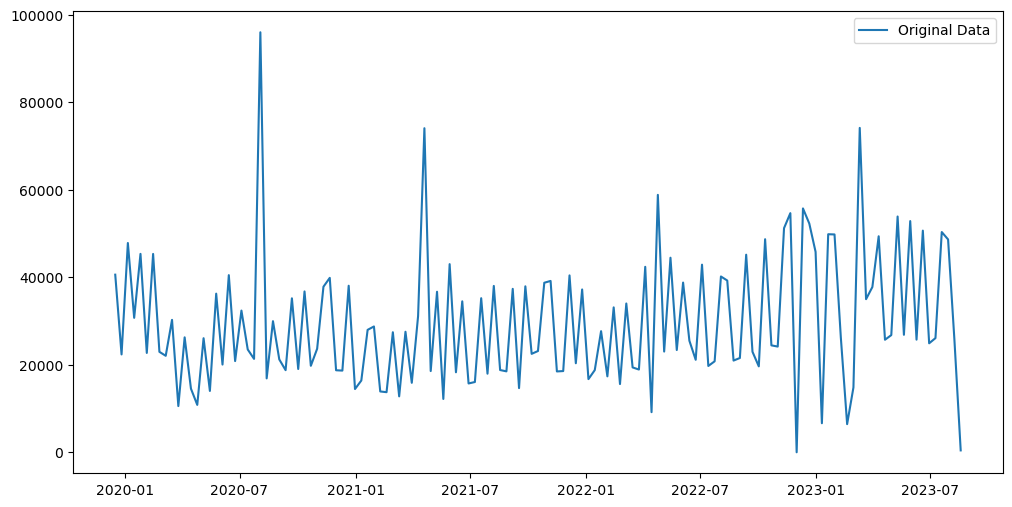

In [8]:
# Plot the data to check for trend and seasonality
plt.figure(figsize=(12, 6))
plt.plot(df_10d, label='Original Data')
plt.legend(loc='best')
plt.show()

####   The decomposition will be additive.

The image shows the amount of data over time. The trend of the data is linear, which means that the data is additive. If the trend of the data were nonlinear, then the decomposition would be multiplicative.

In [9]:
### Checking for stationarity

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['Invoice Amount'], autolag = 'AIC')

print('1 ADF :', dftest[0])
print('2, p-value :',dftest[1])
print('3, Num of lags :',dftest[2])
print('4, Critical values:')

for key, val in dftest[4].items():
    print('\t',key," : ",val)

1 ADF : -6.640203744964575
2, p-value : 5.434044072889039e-09
3, Num of lags : 3
4, Critical values:
	 1%  :  -3.453261605529366
	 5%  :  -2.87162848654246
	 10%  :  -2.5721455328896603


####  In the ADF method :
There are chances that our data might be stationary.

####  Plotting PACF and ACF that will give us the order of AR and MA models respectively

D:\New folder\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


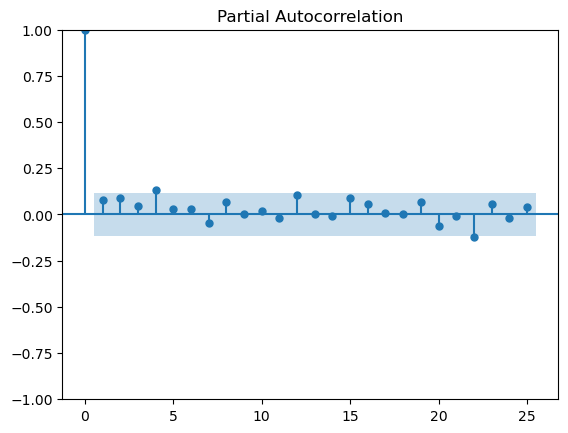

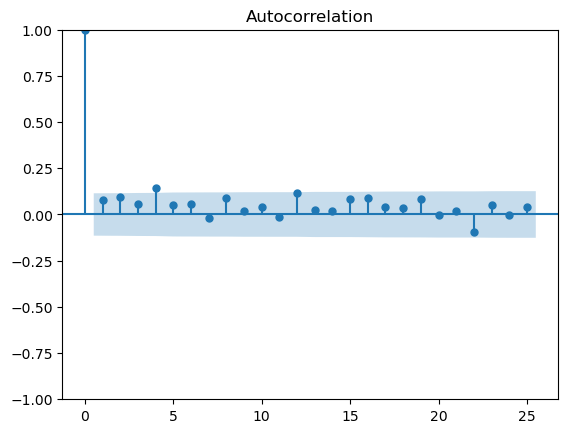

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
pacf = plot_pacf(df['Invoice Amount'], lags = 25)
acf = plot_acf(df['Invoice Amount'],lags = 25)

#### Smoothing

<Axes: xlabel='Invoice Date'>

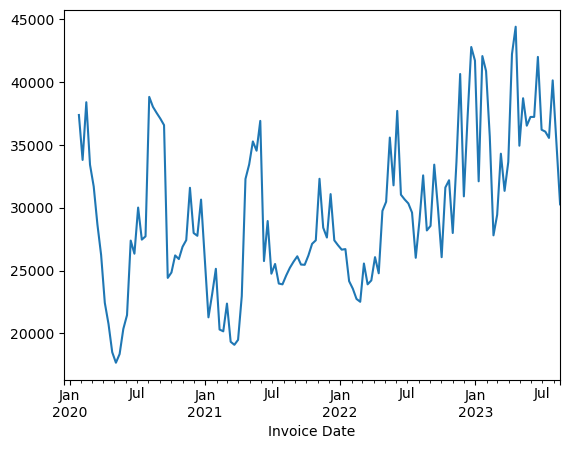

In [11]:
mean_invoice = data_10d.rolling(window = 5).mean()
mean_invoice.plot()

####  Decompositon

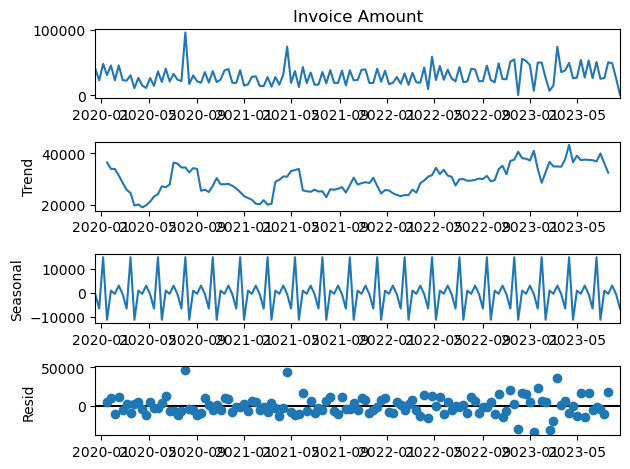

In [12]:
# Decompose the time series data
decomposition = seasonal_decompose(data_10d, model='additive')

# Plot the decomposition components (trend, seasonal, residual)
decomposition.plot()
plt.show()

####  From this graph, we can learn that the amount of data is increasing over time, and there is a monthly seasonality. We can also see that there is some random variation in the data.


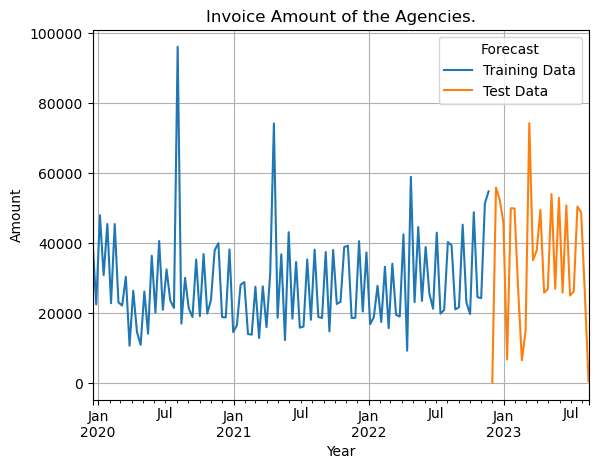

In [13]:
# Split data into train and test sets
train_size = int(len(df_10d) * 0.8)
train, test = df_10d[:train_size], df_10d[train_size:]

train['Invoice Amount'].plot()
test['Invoice Amount'].plot()
plt.grid()
plt.title('Invoice Amount of the Agencies.')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend(['Training Data','Test Data'],title='Forecast');

In [42]:

# def moving_average_model(data, window_size):
#     predictions = data.rolling(window=window_size).mean()
#     return predictions

# ma_5 = moving_average_model(train, 5)
# ma_15 = moving_average_model(train, 15)
# ma_30 = moving_average_model(train, 30)

# MA (Moving Average) models
ma_5_model = train.rolling(window=5).mean()
ma_15_model = train.rolling(window=15).mean()
ma_30_model = train.rolling(window=30).mean()

ma_5_ = ma_5.iloc[-1]
ma_15_ = ma_15.iloc[-1]
ma_30_ = ma_5.iloc[-1]

# ARIMA model
arima_model = ARIMA(df_10d['Invoice Amount'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))

# SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=0)
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test))
# Extract the predicted values from sarima_forecast
sarima_forecast_values = sarima_forecast.predicted_mean.values


# Calculate MAE and R-squared for each model
mae_ma_5 = mean_absolute_error(test, [ma_5_] * len(test))
mae_ma_15 = mean_absolute_error(test, [ma_15_] * len(test))
mae_ma_30 = mean_absolute_error(test, [ma_30_] * len(test))
mae_arima = mean_absolute_error(test, arima_forecast)
mae_sarima = mean_absolute_error(test, sarima_forecast_values)

r2_ma_5 = r2_score(test, [ma_5_] * len(test))
r2_ma_15 = r2_score(test, [ma_15_] * len(test))
r2_ma_30 = r2_score(test, [ma_30_] * len(test))
r2_arima = r2_score(test, arima_forecast)
r2_sarima = r2_score(test, sarima_forecast_values)

# Print MAE and R-squared for each model
print(f"MAE (MA-5): {mae_ma_5}, R-squared: {r2_ma_5}")
print(f"MAE (MA-15): {mae_ma_15}, R-squared: {r2_ma_15}")
print(f"MAE (MA-30): {mae_ma_30}, R-squared: {r2_ma_30}")
print(f"MAE (ARIMA): {mae_arima}, R-squared: {r2_arima}")

print(f"MAE (SARIMA): {mae_sarima}, R-squared: {r2_sarima}")

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)


MAE (MA-5): 16522.96607407407, R-squared: -0.09345675709645129
MAE (MA-15): 16172.37150617284, R-squared: -0.00950469597372261
MAE (MA-30): 16522.96607407407, R-squared: -0.09345675709645129
MAE (ARIMA): 16514.87184411743, R-squared: -0.07865382283356959
MAE (SARIMA): 18791.206160502385, R-squared: -0.5140830233610705


In [41]:
#AutoReg
model = AutoReg(train, lags = 30).fit()
# print(model.summary())

auto_Reg = model.predict(start = len(train), end = len(df_10d) -1 , dynamic = False)

mae_auto_reg = mean_absolute_error(test, auto_Reg)

r2_auto_reg = r2_score(test , auto_Reg )

print(f"MAE (auto_reg): {mae_auto_reg}, R-squared: {r2_auto_reg}")

MAE (auto_reg): 16009.759579456111, R-squared: -0.153188912005082


D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


####  Storing each r2 in the dictionary

In [33]:
r2_dict = {}

# Calculate R-squared for each model and store it in the dictionary
# r2_dict['MA-5'] = r2_ma_5
# r2_dict['MA-15'] = r2_ma_15
# r2_dict['MA-30'] = r2_ma_30
r2_dict['ARIMA'] = r2_arima
r2_dict['SARIMA'] = r2_sarima
r2_dict['AutoReg'] = r2_auto_reg

# Function to select the model with the highest R-squared value
def select_best_model(r2_dict):
    best_model = max(r2_dict, key=r2_dict.get)
    best_r2 = r2_dict[best_model]
    return best_model, best_r2

# Find the best model
best_model, best_r2 = select_best_model(r2_dict)

# Print the results
print(f"Best Model: {best_model}, R-squared: {best_r2}")

Best Model: ARIMA, R-squared: -0.07865382283356959


#### Plot the predictions for each model 

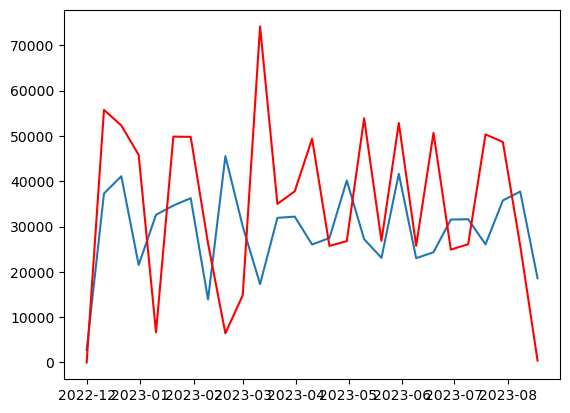

In [18]:
from matplotlib import pyplot
pyplot.plot(auto_Reg)
pyplot.plot(test , color = 'red')


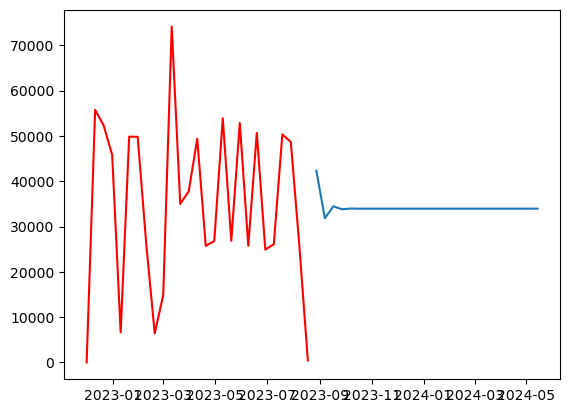

In [19]:
#ARIMA Model

pyplot.plot(arima_forecast)
pyplot.plot(test , color = 'red')

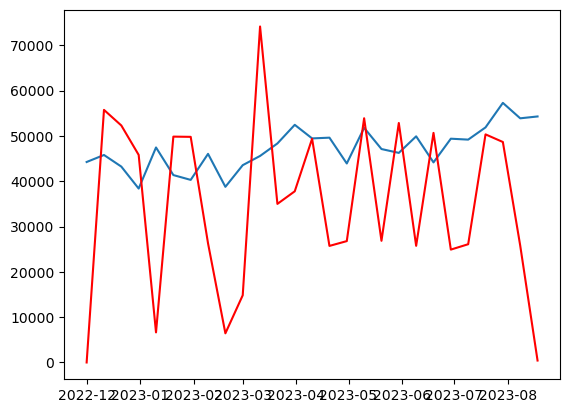

In [20]:
#SARIMA Model

pyplot.plot(sarima_forecast_values)
pyplot.plot(test , color = 'red')

####  Making future predictions:

In [34]:
pred_future = model.predict(start = len(df_10d)+1, end = len(df_10d)+7, dynamic = False)
print("Prediction for future")
print(pred_future)
print('Number of prediction', len(pred_future))

Prediction for future
2023-09-07    27630.535442
2023-09-17    30407.620802
2023-09-27    26218.884010
2023-10-07    32063.378940
2023-10-17    30707.597913
2023-10-27    23434.708844
2023-11-06    38536.412431
Freq: 10D, dtype: float64
Number of prediction 7


D:\New folder\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [39]:
## For ARIMA Model

num_steps = 7  # Change this to the number of steps you want to predict

# Make future predictions
arima_forecast = arima_model_fit.forecast(steps=num_steps)

# Print the future predictions
print("Prediction for future")
print(arima_forecast)
print('Number of predictions:', len(arima_forecast))

Prediction for future
2023-08-28    42311.459665
2023-09-07    31859.592975
2023-09-17    34467.868528
2023-09-27    33816.970314
2023-10-07    33979.402725
2023-10-17    33938.867527
2023-10-27    33948.983133
Freq: 10D, Name: predicted_mean, dtype: float64
Number of predictions: 7


In [40]:
num_steps = 7  # Change this to the number of steps you want to predict

# Make future predictions
sarima_forecast = sarima_model_fit.get_forecast(steps=num_steps)

# Extract the predicted mean values
sarima_forecast_values = sarima_forecast.predicted_mean

# Print the future predictions
print("Prediction for future")
print(sarima_forecast_values)
print('Number of predictions:', len(sarima_forecast_values))

Prediction for future
2022-12-01    44249.630089
2022-12-11    45799.004881
2022-12-21    43232.673030
2022-12-31    38386.922015
2023-01-10    47458.937240
2023-01-20    41364.902344
2023-01-30    40300.481837
Freq: 10D, Name: predicted_mean, dtype: float64
Number of predictions: 7


####  Save the trained model

In [22]:
import pickle

### Creating the pickle file for best model

In [43]:
# Function to save the best model as a pickle file
def save_best_model(best_model):
    mods = {
        # 'MA-5': ma_5,
        # 'MA-15': ma_15,
        # 'MA-30': ma_30,
        'ARIMA': arima_model_fit,
        'SARIMA': sarima_model_fit,
        'AutoReg': model,  # AutoReg model
    }
    # Get the selected model from the switch statement
    selected_model = mods.get(best_model)
    with open('myModel.pkl' , 'wb') as f:
        pickle.dump(selected_model, f)
# Call the function to save the best model
save_best_model(best_model)